# SD212: Graph mining
## Lab 6: Spectral embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [2]:
from IPython.display import SVG

In [3]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [4]:
from sknetwork.data import load_netset, karate_club, linear_graph
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph
from sknetwork.path import get_distances

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [7]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [5]:
dataset = karate_club(metadata=True)

In [6]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

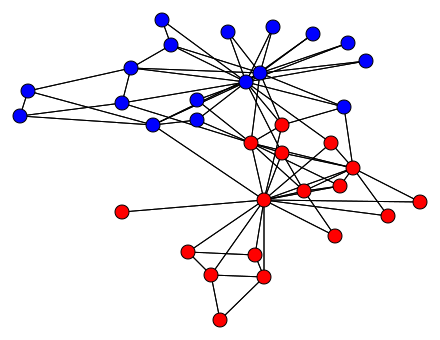

In [7]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first dimension to the ground-truth clusters.

In [8]:
spectral = Spectral(20, normalized=False)

In [9]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

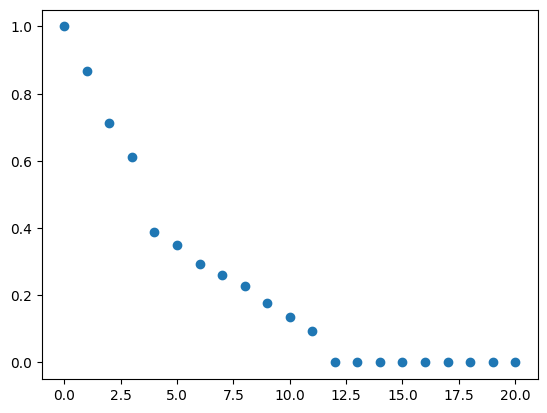

In [10]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

plt.scatter(np.arange(len(eigenvalues)), eigenvalues)

In [11]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

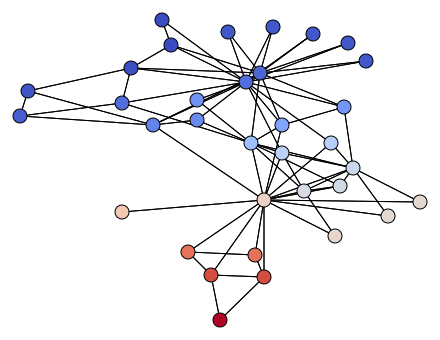

In [12]:
# display eigenvector
image = svg_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

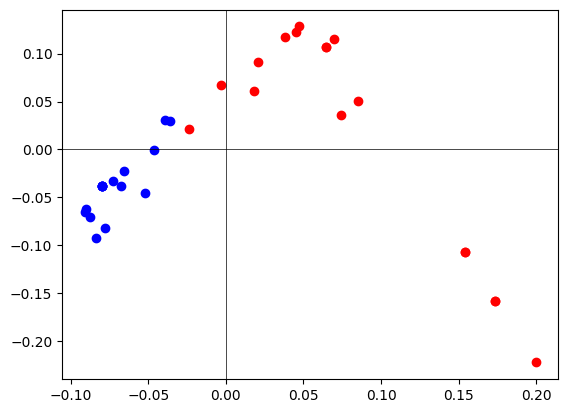

In [13]:
# display the embedding graph in 2D

embedding = spectral.embedding_

COLORS = ['blue', 'red']
plt.axvline(0, linewidth=0.5, c='k')
plt.axhline(0, linewidth=0.5, c='k')

for l in np.unique(labels_true):
    nodes = np.argwhere(labels_true == l).ravel()
    plt.scatter(embedding[nodes,0], embedding[nodes,1], color=COLORS[l])

Misclassified nodes:  17


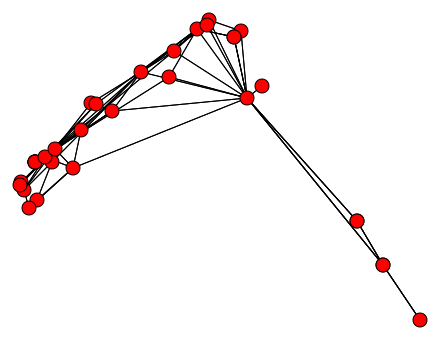

In [14]:
spectral = Spectral(2, normalized=False)
embedding = spectral.fit_transform(adjacency)
eigenvalues = spectral.eigenvalues_
labels = np.array([eigenvalues[0] > 0 for i in range(labels_true.shape[0])])
print("Misclassified nodes: ", np.argwhere(labels_true!= labels).shape[0])
image = svg_graph(adjacency, embedding, labels=labels)
SVG(image)


In [15]:
degrees = adjacency @ np.ones(adjacency.shape[0])
np.mean(sparse.diags(degrees)@embedding, axis=0) 

array([3.13474736e-16, 0.00000000e+00])

Misclassified nodes:  32
[[ 0]
 [ 1]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]]


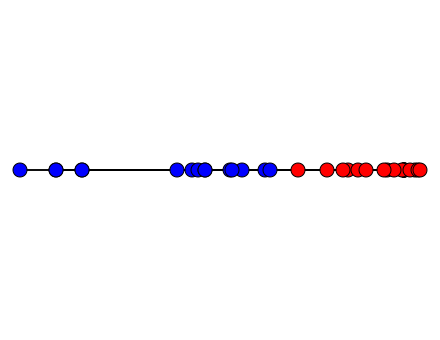

In [16]:
spectral = Spectral(1, normalized=False)
embedding = spectral.fit_transform(adjacency)
emb = np.c_[embedding, np.zeros(embedding.shape[0])]
labels = np.array([embedding[i, 0] > 0 for i in range(labels_true.shape[0])])

print("Misclassified nodes: ", np.argwhere(labels_true != labels).shape[0])
print(np.argwhere(labels_true != labels))
image = svg_graph(adjacency, emb, labels=labels)
SVG(image)

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [8]:
dataset = openflights

In [9]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

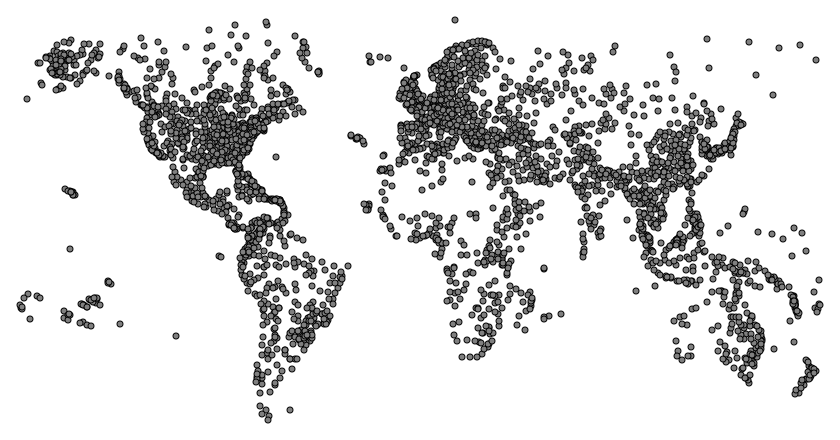

In [10]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. You might compute the distance of the barycenter of each cluster to the origin.

In [20]:
spectral = Spectral(20, normalized=True)

In [21]:
embedding = spectral.fit_transform(adjacency)

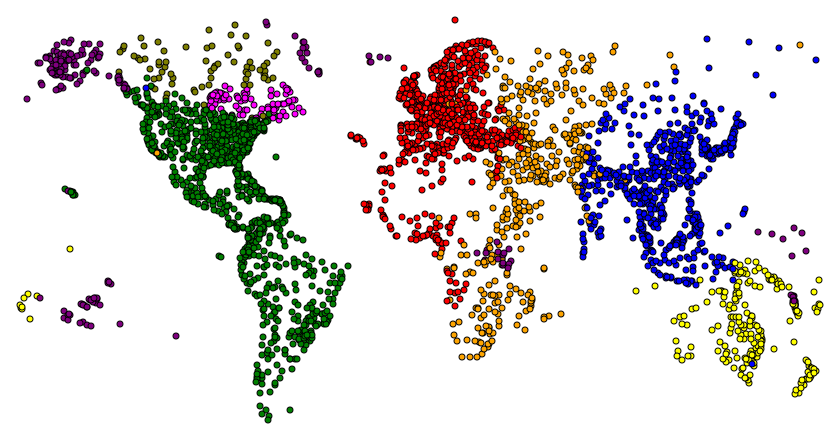

In [22]:
# Display the same world map with 8 clusters found by k-means in the embedding space.
from sklearn.cluster import KMeans

kmeans = KMeans(8, n_init='auto')
labels = kmeans.fit_predict(embedding)

image = svg_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
display(SVG(image))


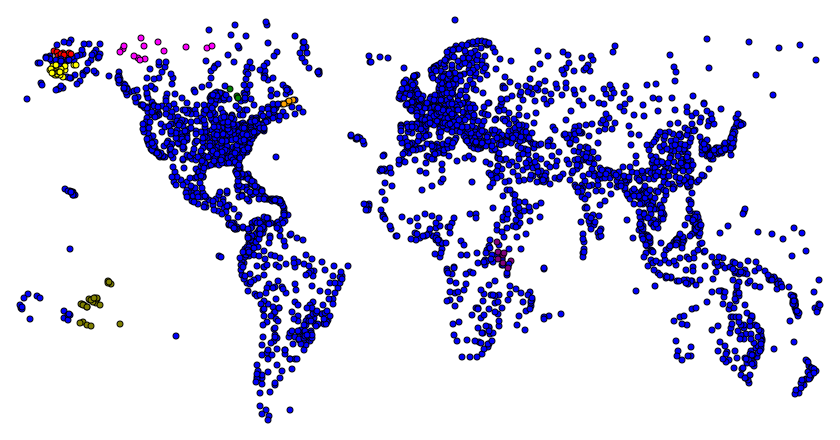

In [23]:
spectral = Spectral(20, normalized=False)

embedding = spectral.fit_transform(adjacency)

# Display the same world map with 8 clusters found by k-means in the embedding space.

kmeans = KMeans(8, n_init='auto')
labels = kmeans.fit_predict(embedding)

image = svg_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
display(SVG(image))

In [14]:
source = np.flatnonzero(names=='Charles de Gaulle International Airport')
distances = get_distances(adjacency, source)

# Print the 10 most distant airports from Charles de Gaulle.

indices = np.argmax(distances)
print(names[indices])


Peawanuck Airport


## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we consider the embedding on the unit sphere (``normalized=True``).

## Wikipedia Vitals

In [24]:
dataset = wikivitals

In [25]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.
* Display the 3D-plot of each label in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the barycenter of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot.
* Display the dendrogram of the top-100 articles on **Arts** (in terms of Personalized PageRank) given by the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space (hierarchical clustering).

In [1]:
import plotly.express as px

# List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.

In [2]:
from scipy.cluster.hierarchy import linkage

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

## To do

* Prove that the average cosine similarity between nodes in some set $S$ is equal to the square distance of the barycenter of $S$ to the origin.

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). 

# Quiz

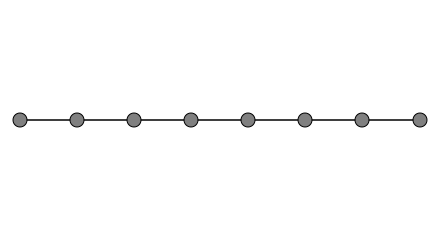

array([-1.87938524, -1.53208889, -1.        , -0.34729636,  0.34729636,
        1.        ,  1.53208889,  1.87938524])

In [ ]:
# linear graph of 8 nodes
graph = linear_graph(8, metadata=True)

# adjacency matrix
adjacency = graph.adjacency
position = graph.position

image = svg_graph(adjacency, position, width=400, height=200)
SVG(image)
display(SVG(image))

# eigenvalues of the Laplacian
D = sparse.diags(adjacency.sum(axis=0).A.ravel())
laplacian = D - adjacency

eigenvalues = np.linalg.eigvalsh(adjacency.toarray())
eigenvalues

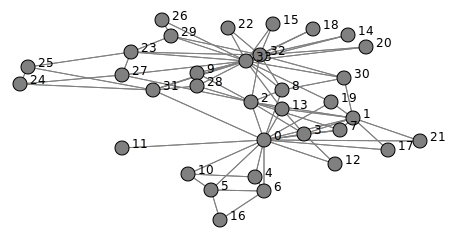

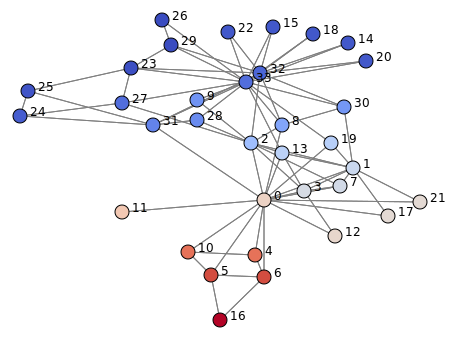

(11, 29)

In [ ]:
graph = karate_club(metadata=True)

adjacency = graph.adjacency
position = graph.position

image = svg_graph(adjacency, position, width=400, height=200, names=np.arange(len(position)))
SVG(image)
display(SVG(image))

spectral = Spectral(3, normalized=False)


embedding = spectral.fit_transform(adjacency)

eigenvalues = spectral.eigenvalues_
eigenvectors = spectral.eigenvectors_

# display eigenvector
image = svg_graph(adjacency, position, scores=eigenvectors[:, 0], names=np.arange(len(position)))
SVG(image)
display(SVG(image))

# What is the pair of most distant nodes in terms of cosine similarity in the embedding space?
from scipy.spatial.distance import pdist, squareform

distances = pdist(embedding, metric='cosine')
distances = squareform(distances)
np.unravel_index(np.argmax(distances), distances.shape)

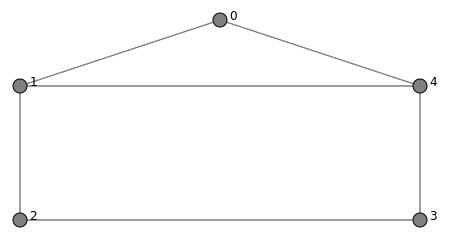

[[ 2. -1.  0.  0. -1.]
 [-1.  3. -1.  0. -1.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [-1. -1.  0. -1.  3.]]
[-5.00000000e-01+0.j  3.33333333e-01+0.j  1.00000000e+00+0.j
 -8.33333333e-01+0.j -2.42861287e-17+0.j]
[[ 7.84464541e-01 -5.57086015e-01 -4.47213595e-01  4.01537044e-17
   3.24879539e-17]
 [-3.92232270e-01 -1.85695338e-01 -4.47213595e-01  3.92232270e-01
   5.00000000e-01]
 [ 1.96116135e-01  5.57086015e-01 -4.47213595e-01 -5.88348405e-01
   5.00000000e-01]
 [ 1.96116135e-01  5.57086015e-01 -4.47213595e-01  5.88348405e-01
  -5.00000000e-01]
 [-3.92232270e-01 -1.85695338e-01 -4.47213595e-01 -3.92232270e-01
  -5.00000000e-01]]


In [15]:
from sknetwork.data import house

house = house(metadata=True)

adjacency = house.adjacency
position = house.position
names = np.arange(len(position))

image = svg_graph(adjacency, position, names=names, width=400, height=200)
display(SVG(image))

# compute the Laplacian
degrees = adjacency.sum(axis=0).A.ravel()
D = sparse.diags(degrees)
laplacian = D - adjacency

print(laplacian.toarray())

D_invert = sparse.diags(1/degrees)


# The top 3 eigenvalues of the transition matrix are 1, 1/3, 0. Give the corresponding right eigenvectors.
from scipy.linalg import eig

eigenvalues, eigenvectors = eig((D_invert.dot(adjacency)).toarray(), left=False, right=True)
print(eigenvalues)
print(eigenvectors)
